# LeNet Lab
![LeNet Architecture](lenet.png)
Source: Yan LeCun

## Load Data

Load the MNIST data, which comes pre-loaded with TensorFlow.

You do not need to modify this section.

In [38]:
#Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train           = train['features'], train['labels']
x_test, y_test             = test['features'], test['labels']

The MNIST data that TensorFlow pre-loads comes as 28x28x1 images.

However, the LeNet architecture only accepts 32x32xC images, where C is the number of color channels.

In order to reformat the MNIST data into a shape that LeNet will accept, we pad the data with two rows of zeros on the top and bottom, and two columns of zeros on the left and right (28+2+2 = 32).

You do not need to modify this section.

In [43]:
from sklearn.model_selection import train_test_split

x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=0)
    
print("Updated Image Shape: {}".format(x_train[0].shape))

Updated Image Shape: (32, 32, 3)


## Visualize Data

View a sample from the dataset.

You do not need to modify this section.

13


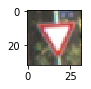

In [44]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import os
import cv2
from math import floor, ceil, pi

%matplotlib inline


import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(x_train))
image = x_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

## Preprocess Data

Shuffle the training data.

You do not need to modify this section.

In [45]:
from sklearn.utils import shuffle

x_train, y_train = shuffle(x_train, y_train)

## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

You do not need to modify this section.

In [60]:
import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle
from skimage import exposure

def preprocess_dataset(X, y = None):
    #Convert to grayscale, e.g. single Y channel
    X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]
    #Scale features to be in [0, 1]
    X = (X / 255.).astype(np.float32)
      
    # Apply localized histogram localization  
    for i in range(X.shape[0]):
        X[i] = exposure.equalize_adapthist(X[i])
        
    if y is not None:  
        # Convert to one-hot encoding. Convert back with `y = y.nonzero()[1]`
        y = np.eye(43)[y]
        # Shuffle the data
        X, y = shuffle(X, y)

    # Add a single grayscale channel
    X = X.reshape(X.shape + (1,)) 
    return X, y

import numpy as np

def flip_extend(X, y):
    # Classes of signs that, when flipped horizontally, should still be classified as the same class
    self_flippable_horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    # Classes of signs that, when flipped vertically, should still be classified as the same class
    self_flippable_vertically = np.array([1, 5, 12, 15, 17])
    # Classes of signs that, when flipped horizontally and then vertically, should still be classified as the same class
    self_flippable_both = np.array([32, 40])
    # Classes of signs that, when flipped horizontally, would still be meaningful, but should be classified as some other class
    cross_flippable = np.array([
        [19, 20], 
        [33, 34], 
        [36, 37], 
        [38, 39],
        [20, 19], 
        [34, 33], 
        [37, 36], 
        [39, 38],   
    ])
    num_classes = 43
    
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
    y_extended = np.empty([0], dtype = y.dtype)
    
    for c in range(num_classes):
        # First copy existing data for this class
        X_extended = np.append(X_extended, X[y == c], axis = 0)
        # If we can flip images of this class horizontally and they would still belong to said class...
        if c in self_flippable_horizontally:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X[y == c][:, :, ::-1, :], axis = 0)
        # If we can flip images of this class horizontally and they would belong to other class...
        if c in cross_flippable[:, 0]:
            # ...Copy flipped images of that other class to the extended array.
            flip_class = cross_flippable[cross_flippable[:, 0] == c][0][1]
            X_extended = np.append(X_extended, X[y == flip_class][:, :, ::-1, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        # If we can flip images of this class vertically and they would still belong to said class...
        if c in self_flippable_vertically:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, :, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        # If we can flip images of this class horizontally AND vertically and they would still belong to said class...
        if c in self_flippable_both:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, ::-1, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
    
    return (X_extended, y_extended)


from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform

def rotate(X, intensity):
    for i in range(X.shape[0]):
        delta = 30. * intensity # scale using augmentation intensity
        X[i] = rotate(X[i], random.uniform(-delta, delta), mode = 'edge')
    return X  

def apply_projection_transform(X, intensity):
    image_size = X.shape[1]
    d = image_size * 0.3 * intensity
    for i in range(X.shape[0]):
        tl_top = random.uniform(-d, d)     # Top left corner, top margin
        tl_left = random.uniform(-d, d)    # Top left corner, left margin
        bl_bottom = random.uniform(-d, d)  # Bottom left corner, bottom margin
        bl_left = random.uniform(-d, d)    # Bottom left corner, left margin
        tr_top = random.uniform(-d, d)     # Top right corner, top margin
        tr_right = random.uniform(-d, d)   # Top right corner, right margin
        br_bottom = random.uniform(-d, d)  # Bottom right corner, bottom margin
        br_right = random.uniform(-d, d)   # Bottom right corner, right margin

        transform = ProjectiveTransform()
        transform.estimate(np.array((
                (tl_left, tl_top),
                (bl_left, image_size - bl_bottom),
                (image_size - br_right, image_size - br_bottom),
                (image_size - tr_right, tr_top)
            )), np.array((
                (0, 0),
                (0, image_size),
                (image_size, image_size),
                (image_size, 0)
            )))
        X[i] = warp(X[i], transform, output_shape=(image_size, image_size), order = 1, mode = 'edge')

    return X


EPOCHS = 30
BATCH_SIZE = 128

## TODO: Implement LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

This is the only cell you need to edit.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [61]:
from tensorflow.contrib.layers import flatten
keep_prob = tf.placeholder_with_default(1.0, shape=())

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.

    # Layer 1 - 28*28*1 to 14*14*32
    # FORMULA: new_height = (input_height - filter_height + 2 * P)/S + 1
    # FORMULA: new_width = (input_width - filter_width + 2 * P)/S + 1
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(conv1, keep_prob)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.dropout(conv2, keep_prob)
    
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
        
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # TODO: Activation.
    fc1    = tf.nn.relu(fc1)
    
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # TODO: Activation.
    fc2    = tf.nn.relu(fc2)
    
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [62]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

In [63]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [64]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [68]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    num_examples = len(x_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        x_train, y_train = shuffle(x_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = x_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(x_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

INFO:tensorflow:Restoring parameters from ./lenet
Training...

EPOCH 1 ...
Validation Accuracy = 0.915

EPOCH 2 ...
Validation Accuracy = 0.933

EPOCH 3 ...
Validation Accuracy = 0.930

EPOCH 4 ...
Validation Accuracy = 0.937

EPOCH 5 ...
Validation Accuracy = 0.936

EPOCH 6 ...
Validation Accuracy = 0.940

EPOCH 7 ...
Validation Accuracy = 0.940

EPOCH 8 ...
Validation Accuracy = 0.939

EPOCH 9 ...
Validation Accuracy = 0.947

EPOCH 10 ...
Validation Accuracy = 0.924

EPOCH 11 ...
Validation Accuracy = 0.949

EPOCH 12 ...
Validation Accuracy = 0.949

EPOCH 13 ...
Validation Accuracy = 0.951

EPOCH 14 ...
Validation Accuracy = 0.955

EPOCH 15 ...
Validation Accuracy = 0.937

EPOCH 16 ...
Validation Accuracy = 0.942

EPOCH 17 ...
Validation Accuracy = 0.960

EPOCH 18 ...
Validation Accuracy = 0.961

EPOCH 19 ...
Validation Accuracy = 0.949

EPOCH 20 ...
Validation Accuracy = 0.962

EPOCH 21 ...
Validation Accuracy = 0.957

EPOCH 22 ...
Validation Accuracy = 0.957

EPOCH 23 ...
Validatio

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [67]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(x_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.846
